# 05a – Journey Time Mapping: Acute to CDC & Community Hospitals

This notebook extends the geospatial travel time exploration by focusing on **LSOA-to-LSOA journey times** between:
- **Acute NHS Hospitals**
- **Community Diagnostic Centres (CDCs)**
- **Community Hospitals**  
within the **NHS South West** region.

---

## Objectives:
- Import and validate location-enriched datasets for acute, CDC, and community sites.
- Filter the master `LSOA_to_LSOA` travel time matrix using `LSOA21CD` codes from each group.
- Compute travel time (by car and public transport) from each **acute hospital LSOA** to all **CDC** and **community hospital LSOAs**.
- Rank journeys by travel time to help identify areas of good or poor access.
- Visualise travel time distributions to highlight accessibility trends.

---

## Datasets Used:
- `NHS_SW_Acute_Hospitals_enriched.csv`
- `NHS_SW_Community_Diagnostic_Centres_enriched.csv`
- `NHS_SW_Community_Hospitals_enriched.csv`
- `LSOA_to_LSOA.csv` – full pairwise travel matrix (~10 million rows)

---

## Outcome:
A set of ranked journey time matrices and visual summaries to support NHS diagnostic and capacity planning across the South West region.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
acute_fp = r"/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/NHS_SW_Acute_Hospitals_enriched.csv"
cdc_fp = r"/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/NHS_SW_ Community_Diagnostic_Centres_enriched.csv"
community_fp = r"/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/NHS_SW_Community_Hospitals_enriched.csv"
travel_fp = r"/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/LSOA_to_LSOA.csv"

# Load data
acute_df = pd.read_csv(acute_fp)
cdc_df = pd.read_csv(cdc_fp)
community_df = pd.read_csv(community_fp)
travel_df = pd.read_csv(travel_fp, header=None, names=[
    "origin_name", "destination_name", "travel_time_car", "travel_time_pt_peak", "travel_time_pt_nonpeak"
])


In [2]:
print("Travel Time shape:", travel_df.shape)
print("Missing travel times:\n", travel_df.isna().sum())


Travel Time shape: (10017225, 5)
Missing travel times:
 origin_name                    0
destination_name               0
travel_time_car            47411
travel_time_pt_peak       450202
travel_time_pt_nonpeak    570523
dtype: int64


In [4]:
# Unique LSOAs
acute_lsoas = acute_df['lsoa21cd'].unique()
cdc_lsoas = cdc_df['lsoa21cd'].unique()
community_lsoas = community_df['lsoa21cd'].unique()


# Filter origin → destination pairs
acute_to_cdc = travel_df[
    (travel_df['origin_name'].isin(acute_lsoas)) &
    (travel_df['destination_name'].isin(cdc_lsoas))
]
acute_to_community = travel_df[
    (travel_df['origin_name'].isin(acute_lsoas)) &
    (travel_df['destination_name'].isin(community_lsoas))
]


In [5]:
# Sort by car travel time
acute_to_cdc_sorted = acute_to_cdc.sort_values(by="travel_time_car")
acute_to_community_sorted = acute_to_community.sort_values(by="travel_time_car")

# Preview
acute_to_cdc_sorted.head(10)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
8944766,E01029231,E01029231,0.000000,0.000000,0.000000
8635493,E01018995,E01018995,0.000000,0.000000,0.000000
5998020,E01032643,E01032644,2.306294,7.696294,7.696294
2670008,E01029302,E01029289,5.353681,12.853681,12.853681
7864615,E01014803,E01014833,7.548888,25.418888,32.418888
4627876,E01020013,E01033234,7.577779,13.607779,14.607779
2907266,E01015251,E01015217,8.172654,22.772654,22.772654
5275609,E01015319,E01015275,8.848827,19.618827,18.398827
6759190,E01029302,E01029282,9.732536,24.132536,24.132536
2232592,E01032000,E01032014,10.291931,NaN,NaN


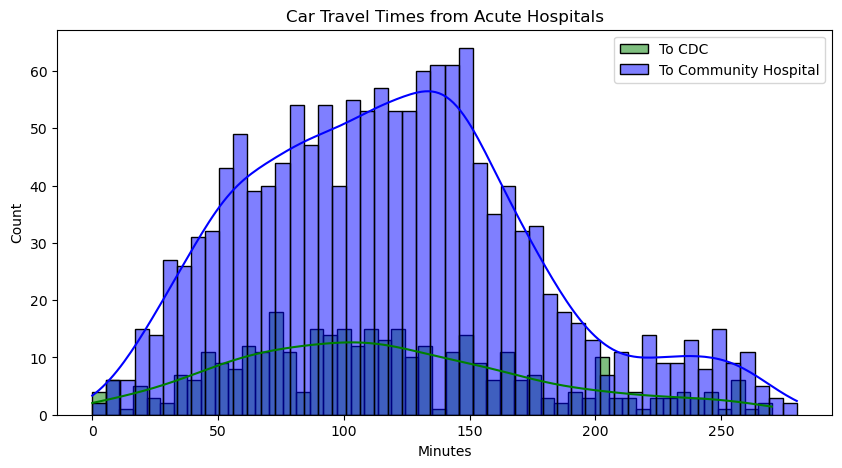

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(acute_to_cdc['travel_time_car'], color='green', bins=50, label='To CDC', kde=True)
sns.histplot(acute_to_community['travel_time_car'], color='blue', bins=50, label='To Community Hospital', kde=True)
plt.legend()
plt.title("Car Travel Times from Acute Hospitals")
plt.xlabel("Minutes")
plt.show()


In [7]:
# Extract LSOA and names
acute_lsoas = acute_df[['lsoa21cd', 'Name']].drop_duplicates()
cdc_lsoas = cdc_df[['lsoa21cd', 'Name']].drop_duplicates()
community_lsoas = community_df[['lsoa21cd', 'Name']].drop_duplicates()

# Filter origin → destination pairs
acute_to_cdc = travel_df[
    (travel_df['origin_name'].isin(acute_lsoas['lsoa21cd'])) &
    (travel_df['destination_name'].isin(cdc_lsoas['lsoa21cd']))
]

acute_to_community = travel_df[
    (travel_df['origin_name'].isin(acute_lsoas['lsoa21cd'])) &
    (travel_df['destination_name'].isin(community_lsoas['lsoa21cd']))
]

# Sort by car travel time
acute_to_cdc_sorted = acute_to_cdc.sort_values(by="travel_time_car")
acute_to_community_sorted = acute_to_community.sort_values(by="travel_time_car")

# Merge to include facility names (optional but helpful)
acute_to_cdc_named = acute_to_cdc_sorted.merge(
    acute_lsoas, how='left', left_on='origin_name', right_on='lsoa21cd'
).merge(
    cdc_lsoas, how='left', left_on='destination_name', right_on='lsoa21cd', suffixes=('_acute', '_cdc')
)

acute_to_community_named = acute_to_community_sorted.merge(
    acute_lsoas, how='left', left_on='origin_name', right_on='lsoa21cd'
).merge(
    community_lsoas, how='left', left_on='destination_name', right_on='lsoa21cd', suffixes=('_acute', '_community')
)

# Preview
acute_to_cdc_named[['Name_acute', 'Name_cdc', 'travel_time_car']].head(10)


,Name_acute,Name_cdc,travel_time_car
0,Yeovil District Hospital,Somerset East CDC,0.000000
1,West Cornwall Hospital (Penzance),West Cornwall CDC,0.000000
2,Dorset County Hospital,Dorset Health Village South Walks CDC,2.306294
3,Musgrove Park Hospital,Taunton Central CDC,5.353681
4,Weston General Hospital,Weston CDC,7.548888
5,Royal Devon & Exeter Hospital (Wonford),Devon Exeter Nightingale CDC,7.577779
6,Torbay Hospital,Devon and Torbay CDC,8.172654
7,Royal Bournemouth Hospital,"Dorset Health Village Boscombe, Aecc CDC",8.848827
8,Musgrove Park Hospital,Somerset West CDC,9.732536
9,Salisbury District Hospital,Salisbury CDC,10.291931


In [8]:
acute_to_cdc_named[['Name_acute', 'Name_cdc', 'travel_time_car']].head(50)

,Name_acute,Name_cdc,travel_time_car
0,Yeovil District Hospital,Somerset East CDC,0.000000
1,West Cornwall Hospital (Penzance),West Cornwall CDC,0.000000
2,Dorset County Hospital,Dorset Health Village South Walks CDC,2.306294
3,Musgrove Park Hospital,Taunton Central CDC,5.353681
4,Weston General Hospital,Weston CDC,7.548888
5,Royal Devon & Exeter Hospital (Wonford),Devon Exeter Nightingale CDC,7.577779
6,Torbay Hospital,Devon and Torbay CDC,8.172654
7,Royal Bournemouth Hospital,"Dorset Health Village Boscombe, Aecc CDC",8.848827
8,Musgrove Park Hospital,Somerset West CDC,9.732536
9,Salisbury District Hospital,Salisbury CDC,10.291931


In [9]:
# Merge acute → community hospital with names
acute_to_community_named = acute_to_community_sorted.merge(
    acute_lsoas, how='left', left_on='origin_name', right_on='lsoa21cd'
).merge(
    community_lsoas, how='left', left_on='destination_name', right_on='lsoa21cd', suffixes=('_acute', '_community')
)

# Preview
acute_to_community_named[['Name_acute', 'Name_community', 'travel_time_car']].head(30)


,Name_acute,Name_community,travel_time_car
0,The Great Western Hospital,Swindon Intermediate Care Centre (Gwh),0.000000
1,Cheltenham General Hospital,Delancey Hospital,5.319528
2,Royal Devon & Exeter Hospital (Wonford),Heavitree Hospital,7.150809
3,Royal Bournemouth Hospital,Kings Park Community Hospital,7.246840
4,Royal Bournemouth Hospital,Boscombe Community Hospital,7.418196
5,Musgrove Park Hospital,Taunton Adult,9.809388
6,Royal Devon & Exeter Hospital (Wonford),Exeter Community Hospital,10.137726
7,Royal Devon & Exeter Hospital (Wonford),Whipton Hospital,10.137726
8,Royal Bournemouth Hospital,Christchurch Hospital,10.730345
9,Portland Hospital,Westhaven Hospital,13.063785
